In [13]:
import os
import pandas as pd
import numpy as np
# from sklearn import linear_model
from scipy.stats import zscore
# import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
# import prol
import math
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import scipy.stats as stats
import seaborn as sns
from treeple.ensemble import PatchObliqueRandomForestRegressor
from sklearn.metrics import r2_score

In [14]:
print(os.getcwd())
data = np.load('group_data_natview_data_fmri_eyetracking1hz.npy',allow_pickle=True)
data_dict = data.item()
# data_dict['data_eyetracking']

/Users/qinazihan/Desktop/Jovo/Nov20


In [15]:
subjects = data_dict['subjects']
sessions = data_dict['sessions']
tasks = data_dict['tasks']

data_brainstates = data_dict['data_fmri']
data_eyetracking = data_dict['data_eyetracking']


In [16]:
brainstates = [ 'tsCAP1', 'tsCAP2', 'tsCAP3', 'tsCAP4', 'tsCAP5', 'tsCAP6', 'tsCAP7', 'tsCAP8']

In [17]:
### Test Cell
key = 'sub-14_ses-01_task-dme_run-01'
window = 12
fmri_ts_mask = (data_brainstates[key]['tsMask'].to_numpy() > 0.5) #TODO what's these two masks based on?
eyetrack_mask = (data_eyetracking[key]['tmask'].to_numpy() > 0.5)

FMRI_TARGET_DATA = data_brainstates[key]['tsCAP5'].to_numpy()
PD_DATA = data_eyetracking[key]['pupil_size'].to_numpy()
Xpos = data_eyetracking[key]['X_position'].to_numpy()
Ypos = data_eyetracking[key]['Y_position'].to_numpy()

PD_DATA_dfirst = np.diff(PD_DATA, prepend=PD_DATA[0])
PD_DATA_dsecond = np.diff(PD_DATA, n=2, prepend=PD_DATA_dfirst[:2])
PREDICTION_FEATURES = np.vstack((PD_DATA, PD_DATA_dfirst, PD_DATA_dsecond)).T
print(FMRI_TARGET_DATA.shape,PREDICTION_FEATURES.shape)

(601,) (601, 3)


In [18]:
### Test Cell
PUPIL = []
FMRI = []
TIME = []
for i in range(0,FMRI_TARGET_DATA.shape[0]-window):
    X = np.reshape(PREDICTION_FEATURES[(i):(i+window),: ].flatten(),(1,-1))
    FEATURE_MASK = eyetrack_mask[(i):(i+window)]
    Y = FMRI_TARGET_DATA[i+window]
    TARGET_MASK = fmri_ts_mask[i+window]
    if np.mean(FEATURE_MASK) >= 0.75 and TARGET_MASK:
        PUPIL.append(X)
        FMRI.append(Y)
        TIME.append(i+window)
    # else:
    #     print(i+window)
PUPIL_DF = np.concatenate(PUPIL)
print(PUPIL_DF.shape,len(FMRI),len(TIME))

(505, 36) 505 505


In [19]:
def Data_Handeler(sub,session,state,task,window=12,mask_thr = 0.75):
    key = 'sub-' + sub+'_ses-'+session +'_task-'+ task
    fmri_ts_mask = (data_brainstates[key]['tsMask'].to_numpy() > 0.5)
    eyetrack_mask = (data_eyetracking[key]['tmask'].to_numpy() > 0.5)

    FMRI_TARGET_DATA = data_brainstates[key][state].to_numpy()
    PD_DATA = data_eyetracking[key]['pupil_size'].to_numpy()
    Xpos = data_eyetracking[key]['X_position'].to_numpy()
    Ypos = data_eyetracking[key]['Y_position'].to_numpy()

    PD_DATA_dfirst = np.diff(PD_DATA, prepend=PD_DATA[0])
    PD_DATA_dsecond = np.diff(PD_DATA, n=2, prepend=PD_DATA_dfirst[:2])
    PREDICTION_FEATURES = np.vstack((PD_DATA, PD_DATA_dfirst, PD_DATA_dsecond)).T
    
    PUPIL = []
    FMRI = []
    TIME = []
    for i in range(0,FMRI_TARGET_DATA.shape[0]-window):
        X = np.reshape(PREDICTION_FEATURES[(i):(i+window),: ].flatten(),(1,-1))
        FEATURE_MASK = eyetrack_mask[(i):(i+window)]
        Y = FMRI_TARGET_DATA[i+window]
        TARGET_MASK = fmri_ts_mask[i+window]
        if np.mean(FEATURE_MASK) >= 0.75 and TARGET_MASK:
            PUPIL.append(X)
            FMRI.append(Y)
            TIME.append(i+window)
    PUPIL_DF = np.concatenate(PUPIL)
    return PUPIL_DF,FMRI,TIME
    

In [20]:
### Test Cell
PUPIL_DF,FMRI,TIME = Data_Handeler(sub = '14',session ='01',state = 'tsCAP5',
                                   task = 'dme_run-01',window=12,mask_thr = 0.75)
print(PUPIL_DF.shape,len(FMRI),len(TIME))

(505, 36) 505 505


In [21]:
### Test Cell
test_sub = '01'
movie = 'dme_run'
session = '01'
state = 'tsCAP5'
SUBJECTS = ['01', '02','03','04', '05','06', '07', '08', '09','10','11','12', '13', '14', '15', '16', '18', '20', '21', '22']
PUPIL_ALL = []
FMRI_ALL = []
TIME_ALL = []
for sub_i in SUBJECTS:
    if sub_i in ['01','02','06','10','12','13','14','15','16','18','20','21']:
        tasks_list = ['dme_run-01']
    else:
        tasks_list = ['dme_run-01']
    for task in tasks_list:
        PUPIL,FMRI,TIME = Data_Handeler(sub = sub_i,session =session,state = state,task = task,window=12,mask_thr = 0.75)
        if sub_i == test_sub:
            PUPIL_TEST = PUPIL
            FMRI_TEST = FMRI
            TIME_TEST = TIME
        else:
            PUPIL_ALL.append(PUPIL)
            FMRI_ALL.extend(FMRI)
            TIME_ALL.extend(TIME)

PUPIL_TRAIN = np.concatenate(PUPIL_ALL)
FMRI_TRAIN = FMRI_ALL
TIME_TRAIN = TIME_ALL
print(PUPIL_TRAIN.shape,len(FMRI_TRAIN),len(TIME_TRAIN))
print(PUPIL_TEST.shape,len(FMRI_TEST),len(TIME_TEST))

reg = Ridge(alpha=1)
reg.fit(PUPIL_TRAIN, FMRI_TRAIN)
ypred = reg.predict(PUPIL_TEST)
print(np.corrcoef(np.array(FMRI_TEST).T,ypred.T)[0,1])

(8299, 36) 8299 8299
(589, 36) 589 589
0.15779148893044576


In [22]:
# Time Encoding
import torch
import torch.nn as nn

class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super(TimeEmbedding, self).__init__()
        self.freqs = (2 * np.pi) / (torch.arange(2, dim + 1, 2))
        self.freqs = self.freqs.unsqueeze(0)

    def forward(self, t):
        self.sin = torch.sin(self.freqs * t)
        self.cos = torch.cos(self.freqs * t)
        return torch.cat([self.sin, self.cos], dim=-1)

def Time_Handeler(t,tdim= 50):
    time_embed = TimeEmbedding(dim=tdim)
    timeembed = []
    for i in range(len(t)):
        timeembed.append(time_embed(t[i]))
    return np.concatenate(timeembed).reshape(-1,tdim)

In [23]:
def Train_Test(test_sub,session,state,time = False,model = 'ridge'):
    SUBJECTS = ['01', '02','03','04', '05','06', '07', '08', '09','10','11','12', '13', '14', '15', '16', '18', '20', '21', '22']
    PUPIL_ALL = []
    FMRI_ALL = []
    TIME_ALL = []
    for sub_i in SUBJECTS:
        if sub_i in ['01','02','06','10','12','13','14','15','16','18','20','21']:
            tasks_list = ['dme_run-01']
        else:
            tasks_list = ['dme_run-01']
        for task in tasks_list:
            PUPIL,FMRI,TIME = Data_Handeler(sub = sub_i,session =session,state = state,task = task,window=12,mask_thr = 0.75)
            if sub_i == test_sub:
                PUPIL_TEST = zscore(PUPIL,axis=1)
                FMRI_TEST = zscore(FMRI)
                TIME_TEST = TIME
            else:
                PUPIL_ALL.append(PUPIL)
                FMRI_ALL.extend(FMRI)
                TIME_ALL.extend(TIME)

    PUPIL_TRAIN = zscore(np.concatenate(PUPIL_ALL),axis = 1)
    FMRI_TRAIN = zscore(FMRI_ALL)
    TIME_TRAIN = TIME_ALL
    # print(PUPIL_TRAIN.shape,len(FMRI_TRAIN),len(TIME_TRAIN))
    # print(PUPIL_TEST.shape,len(FMRI_TEST),len(TIME_TEST))
    if model == 'ridge':
        reg = Ridge(alpha=1)    
    if model == 'rf':
        reg = RandomForestRegressor()
    if model == 'morf':
        reg = PatchObliqueRandomForestRegressor()
    if time:
        TIME_ENCODE_TRAIN = Time_Handeler(TIME_TRAIN)
        # print(TIME_ENCODE_TRAIN.shape)
        PUPIL_TRAIN_TIME = np.hstack((PUPIL_TRAIN,TIME_ENCODE_TRAIN))
        # print(PUPIL_TRAIN_TIME.shape)
        TIME_ENCODE_TEST = Time_Handeler(TIME_TEST)
        PUPIL_TEST_TIME = np.hstack((PUPIL_TEST,TIME_ENCODE_TEST))
    else:
        PUPIL_TRAIN_TIME = PUPIL_TRAIN
        PUPIL_TEST_TIME = PUPIL_TEST
    print(PUPIL_TRAIN_TIME.shape)
    reg.fit(PUPIL_TRAIN_TIME, FMRI_TRAIN)
    ypred_train = reg.predict(PUPIL_TRAIN_TIME)
    ypred = reg.predict(PUPIL_TEST_TIME)
    corr = np.corrcoef(np.array(FMRI_TEST).T,ypred.T)[0,1]
    return FMRI_TRAIN,ypred_train,FMRI_TEST,ypred,corr

In [24]:
session = '01'
state = 'tsCAP5'
CORR = [] 
CORR_TIME = []
R2_score = []
R2_score_TIME = []
SUBJECTS = ['01', '02','03','04', '05','06', '07', '08', '09','10','11','12', '13', '14', '15', '16', '18', '20', '21', '22']
for test_sub in SUBJECTS:
    print(test_sub)
    _,_,FMRI_TEST,ypred,corr = Train_Test(test_sub,session,state,time = False,model = 'ridge')
    R2_score.append(r2_score(FMRI_TEST,ypred))
    CORR.append(corr)
    _,_,FMRI_TEST_time,ypred_time,corr_time = Train_Test(test_sub,session,state,time = True,model = 'ridge')
    CORR_TIME.append(corr_time)
    R2_score_TIME.append(r2_score(FMRI_TEST_time,ypred_time))
    print(corr,corr_time)
    print(r2_score(FMRI_TEST,ypred),r2_score(FMRI_TEST_time,ypred_time))
    

01
(8299, 36)
(8299, 86)
0.19756787366183653 0.40427867966753606
0.03524360347328348 0.1560834435166637
02
(8299, 36)
(8299, 86)
0.245058174206017 0.4101102401551191
0.03864667961472268 0.16362076734863917
03
(8797, 36)
(8797, 86)
0.40966813720898543 0.5025195295177187
0.13819918338038406 0.23785884985075645
04
(8299, 36)
(8299, 86)
0.1346651923899845 0.22436381481156958
0.006789494046963829 0.02944235473345036
05
(8565, 36)
(8565, 86)
0.46569134531358225 0.4072819149543046
0.21583367426945177 0.13973076742326507
06
(8307, 36)
(8307, 86)
0.3661146013842861 0.39481648501676286
0.08357225092098697 0.09838013273488522
07
(8344, 36)
(8344, 86)
0.1120040555850482 0.16624040678026003
0.005716125021420715 -0.006982408422993025
08
(8484, 36)
(8484, 86)
0.23140371023509107 0.3033668207102556
0.052976080684581484 0.08955264185064737
09
(8727, 36)
(8727, 86)
0.2914945886322108 0.43556463939029244
0.07827327092839542 0.18600746176835603
10
(8299, 36)
(8299, 86)
0.20675930253694288 0.35645495584435

13
(8326, 36)
0.5117829691524625


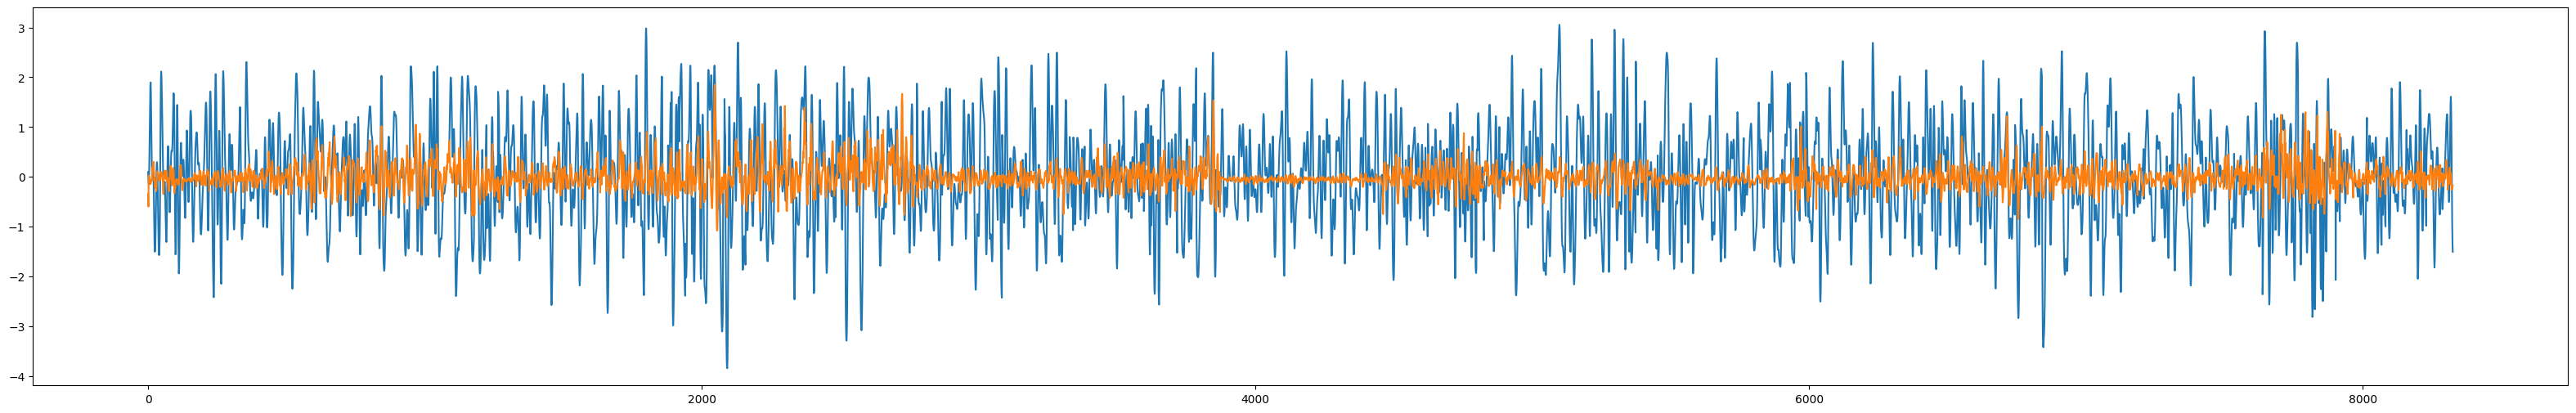

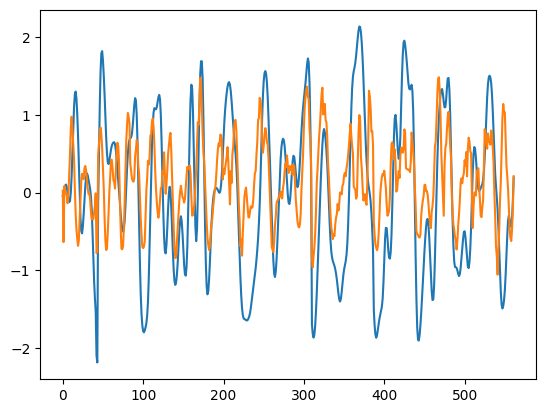

(8326, 86)
0.45281239796599326


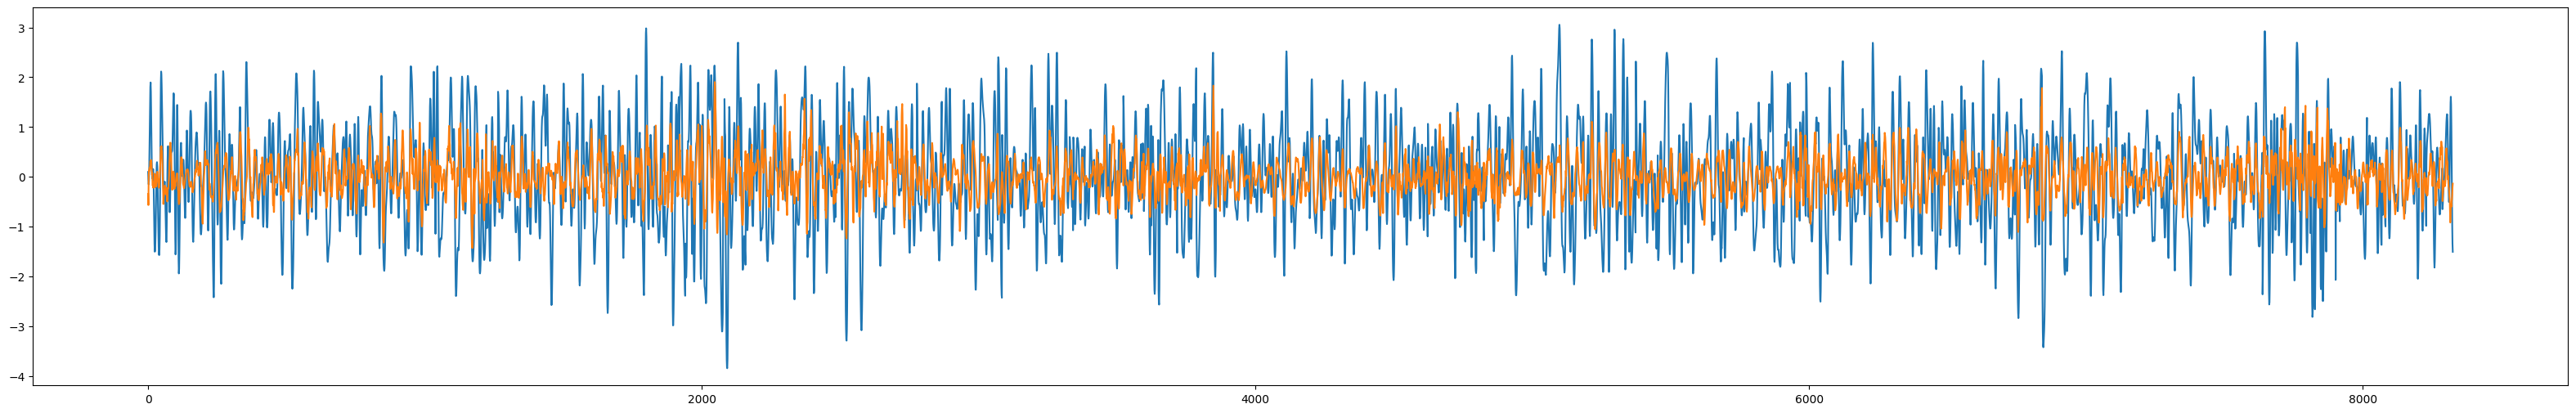

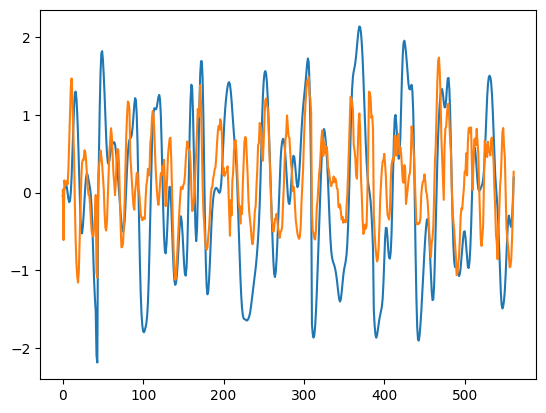

In [25]:
TEST_SUB = ['13',
            # '15','18','21'
            # '10'
            ]
for test_sub in TEST_SUB:
    plt.figure(figsize=(40, 6))
    print(test_sub)
    FMRI_TRAIN,ypred_train,FMRI_TEST,ypred,corr = Train_Test(test_sub,session,state,time = False,model = 'ridge')
    print(corr)
    plt.plot(FMRI_TRAIN)
    plt.plot(ypred_train)
    plt.show()
    plt.plot(FMRI_TEST)
    plt.plot(ypred)
    plt.show()
    
    plt.figure(figsize=(40, 6))
    FMRI_TRAIN,ypred_train,FMRI_TEST,ypred,corr = Train_Test(test_sub,session,state,time = True,model = 'ridge')
    print(corr)
    plt.plot(FMRI_TRAIN)
    plt.plot(ypred_train)
    plt.show()
    plt.plot(FMRI_TEST)
    plt.plot(ypred)
    plt.show()

Text(0.5, 1.0, 'Ridge Regression Correlation')

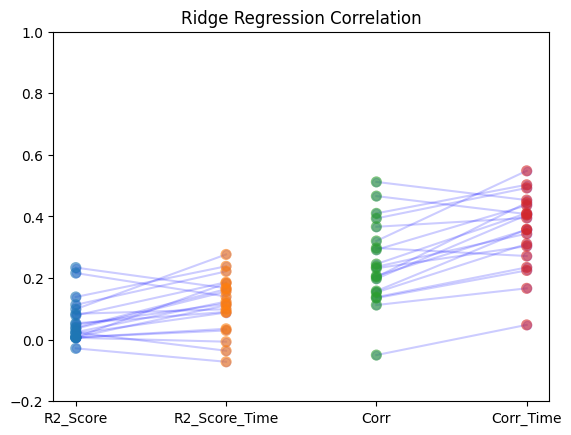

In [26]:
CORR_Ridge = pd.DataFrame(np.hstack((np.array(R2_score).reshape(-1,1),np.array(R2_score_TIME).reshape(-1,1),np.array(CORR).reshape(-1,1),np.array(CORR_TIME).reshape(-1,1))),columns = ['R2_Score','R2_Score_Time','Corr','Corr_Time'])
sns.stripplot(CORR_Ridge,s = 8,alpha = 0.6,jitter = False)
# sns.lineplot(x='Corr_Time',y='Corr',data = corr_df)
for idx, row in CORR_Ridge.iterrows():
    plt.plot([2, 3], [row['Corr'], row['Corr_Time']], color='blue', linestyle='-', marker='o',alpha = 0.2)
for idx, row in CORR_Ridge.iterrows():
    plt.plot([0, 1], [row['R2_Score'], row['R2_Score_Time']], color='blue', linestyle='-', marker='o',alpha = 0.2)
plt.xticks([0, 1,2,3],  ['R2_Score','R2_Score_Time','Corr','Corr_Time'])
plt.ylim([-0.2,1])
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1])
plt.title('Ridge Regression Correlation')


In [27]:
session = '01'
state = 'tsCAP5'
CORR = [] 
CORR_TIME = []
R2_score = []
R2_score_TIME = []
SUBJECTS = ['01', '02','03','04', '05','06', '07', '08', '09','10','11','12', '13', '14', '15', '16', '18', '20', '21', '22']
for test_sub in SUBJECTS:
    print(test_sub)
    _,_,FMRI_TEST,ypred,corr = Train_Test(test_sub,session,state,time = False,model = 'rf')
    R2_score.append(r2_score(FMRI_TEST,ypred))
    CORR.append(corr)
    _,_,FMRI_TEST_time,ypred_time,corr_time = Train_Test(test_sub,session,state,time = True,model = 'rf')
    CORR_TIME.append(corr_time)
    R2_score_TIME.append(r2_score(FMRI_TEST_time,ypred_time))
    print(corr,corr_time)
    print(r2_score(FMRI_TEST,ypred),r2_score(FMRI_TEST_time,ypred_time))
    

01
(8299, 36)
(8299, 86)
0.15662515073270725 0.33850097478793056
0.02103147397092242 0.11305409222897822
02
(8299, 36)
(8299, 86)
0.3175329301499266 0.49951749558586506
0.09145439619990037 0.24634125690316433
03
(8797, 36)
(8797, 86)
0.2856026179445265 0.2193244685374538
0.04519075269450412 0.010362527158319756
04
(8299, 36)
(8299, 86)
0.14053963957031895 0.279704439120493
0.00622848022072775 0.07247921476425245
05
(8565, 36)
(8565, 86)
0.37391274263537205 0.3672208688552992
0.12046109208405198 0.10248268520957171
06
(8307, 36)
(8307, 86)
0.35749466396003216 0.3818543124558047
0.09780297460209886 0.12675493365351165
07
(8344, 36)
(8344, 86)
0.1016976229630868 0.12961835156988002
0.0008618220561982248 -0.034202637134256975
08
(8484, 36)
(8484, 86)
0.12637596962909933 0.21118454041332985
0.005263848176343733 0.020491591919379326
09
(8727, 36)
(8727, 86)
0.42874522875379834 0.4707895116798469
0.16446961548005357 0.2090680507637137
10
(8299, 36)
(8299, 86)
0.023749567999106647 0.3550713579

[0.02103147397092242, 0.09145439619990037, 0.04519075269450412, 0.00622848022072775, 0.12046109208405198, 0.09780297460209886, 0.0008618220561982248, 0.005263848176343733, 0.16446961548005357, -0.03173249742162243, 0.004385213425790679, 0.05770410513577995, 0.3018598263902329, -0.014140065552581627, -0.00023291247642043267, -0.01022228210522469, 0.0675244027435441, 0.00965611439965608, 0.06706216761039885, 0.07010225828477279]
[0.11305409222897822, 0.24634125690316433, 0.010362527158319756, 0.07247921476425245, 0.10248268520957171, 0.12675493365351165, -0.034202637134256975, 0.020491591919379326, 0.2090680507637137, 0.11899402362903422, 0.043502951899104914, 0.15552669431168853, 0.1427043733228751, -0.013126250456127586, 0.2465091653166096, 0.08119993130507663, 0.2739031074729399, 0.08357602965245758, 0.09646825702770834, 0.11328878992212432]


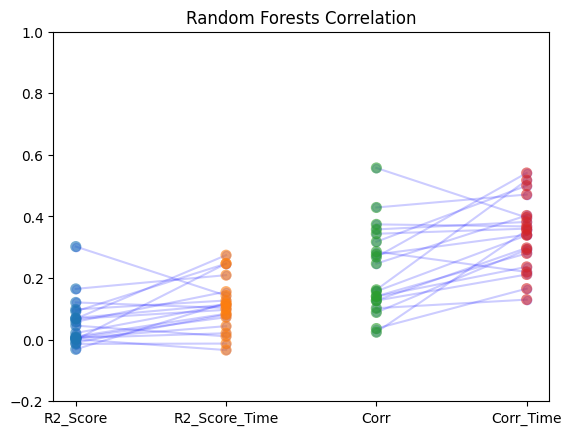

In [28]:
CORR_RF = pd.DataFrame(np.hstack((np.array(R2_score).reshape(-1,1),np.array(R2_score_TIME).reshape(-1,1),np.array(CORR).reshape(-1,1),np.array(CORR_TIME).reshape(-1,1))),columns = ['R2_Score','R2_Score_Time','Corr','Corr_Time'])
sns.stripplot(CORR_RF,s = 8,alpha = 0.6,jitter = False)
# sns.lineplot(x='Corr_Time',y='Corr',data = corr_df)
for idx, row in CORR_RF.iterrows():
    plt.plot([2, 3], [row['Corr'], row['Corr_Time']], color='blue', linestyle='-', marker='o',alpha = 0.2)
for idx, row in CORR_RF.iterrows():
    plt.plot([0, 1], [row['R2_Score'], row['R2_Score_Time']], color='blue', linestyle='-', marker='o',alpha = 0.2)
plt.xticks([0, 1,2,3],  ['R2_Score','R2_Score_Time','Corr','Corr_Time'])
plt.ylim([0,1])
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1])
plt.title('Random Forests Correlation')
print(R2_score)
print(R2_score_TIME)

10
(8299, 36)
-0.0005031799132078049


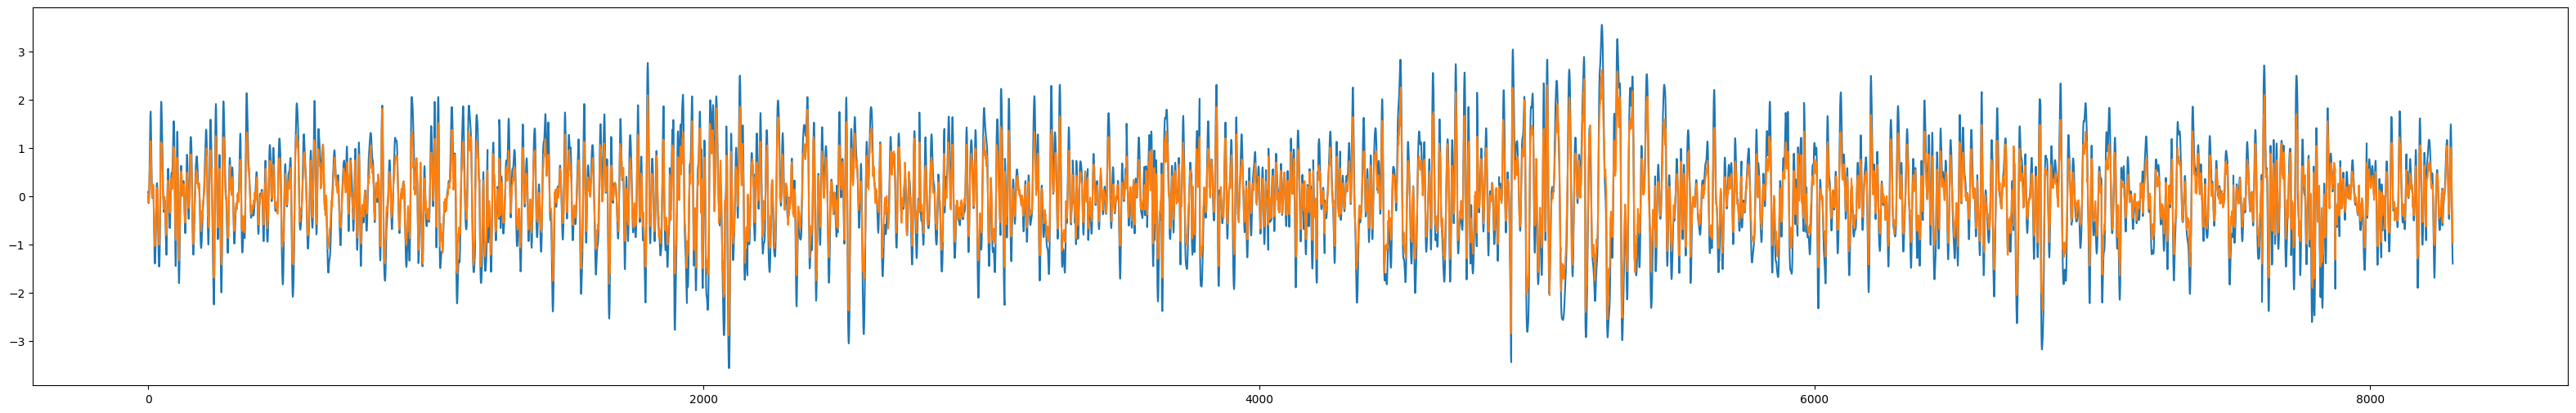

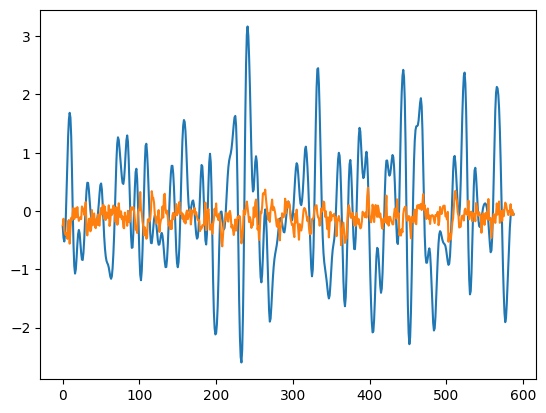

(8299, 86)
0.3689937560653676


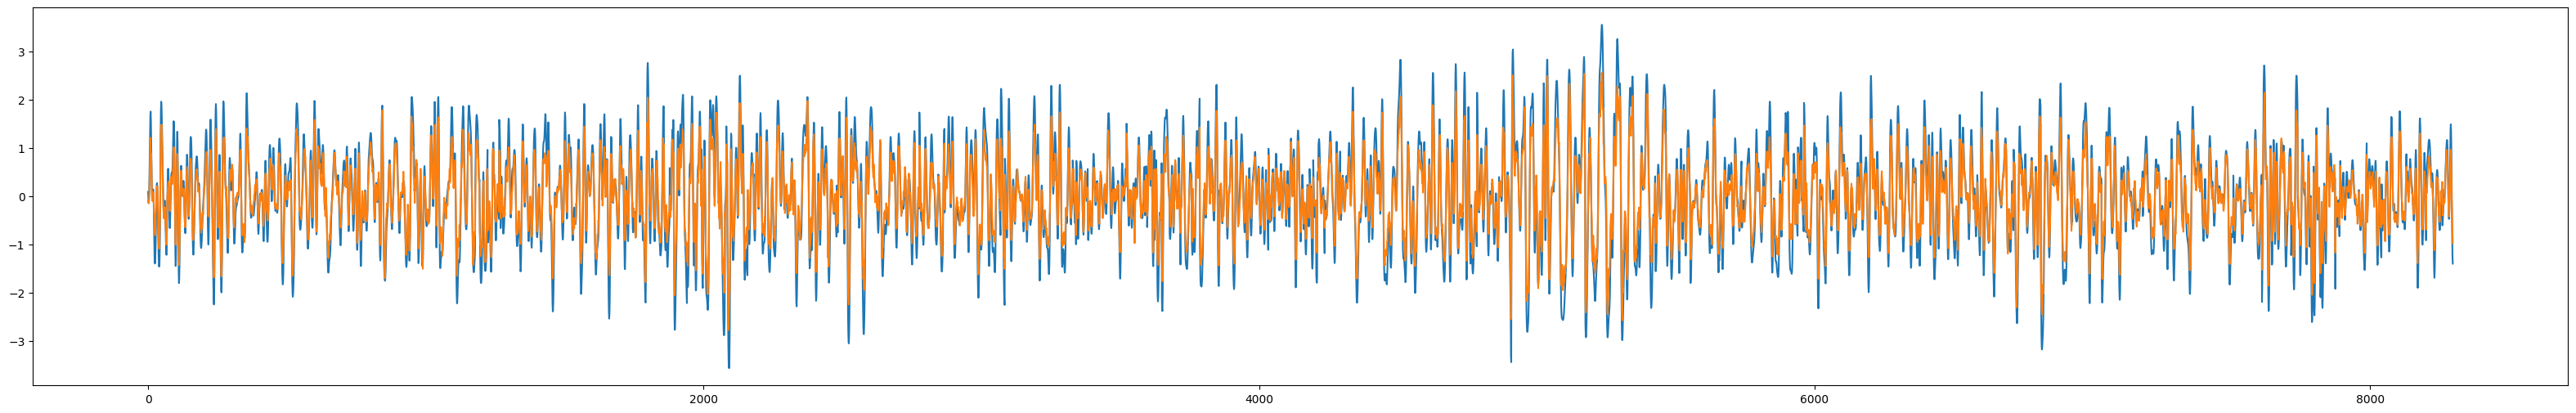

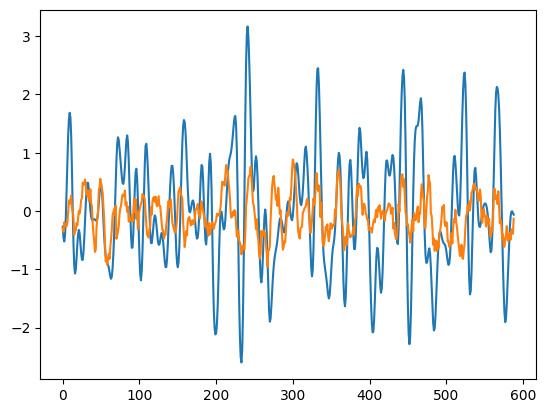

In [29]:
TEST_SUB = ['10',
            # '15','18','21'
            # '10'
            ]
for test_sub in TEST_SUB:
    plt.figure(figsize=(40, 6))
    print(test_sub)
    FMRI_TRAIN,ypred_train,FMRI_TEST,ypred,corr = Train_Test(test_sub,session,state,time = False,model = 'rf')
    print(corr)
    plt.plot(FMRI_TRAIN)
    plt.plot(ypred_train)
    plt.show()
    plt.plot(FMRI_TEST)
    plt.plot(ypred)
    plt.show()
    
    plt.figure(figsize=(40, 6))
    FMRI_TRAIN,ypred_train,FMRI_TEST,ypred,corr = Train_Test(test_sub,session,state,time = True,model = 'rf')
    print(corr)
    plt.plot(FMRI_TRAIN)
    plt.plot(ypred_train)
    plt.show()
    plt.plot(FMRI_TEST)
    plt.plot(ypred)
    plt.show()